# Import libraries requires

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from glob import glob
import seaborn as sns
from PIL import Image
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

# Default input size
SIZE = 32

# Loading dataset

In [2]:
# read the training dataset
train = pd.read_csv('data_labels_mainData.csv')

# display the first 5 rows
train.head(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# Data Distribution Visualization 

Text(0.5, 1.0, 'isCancerous')

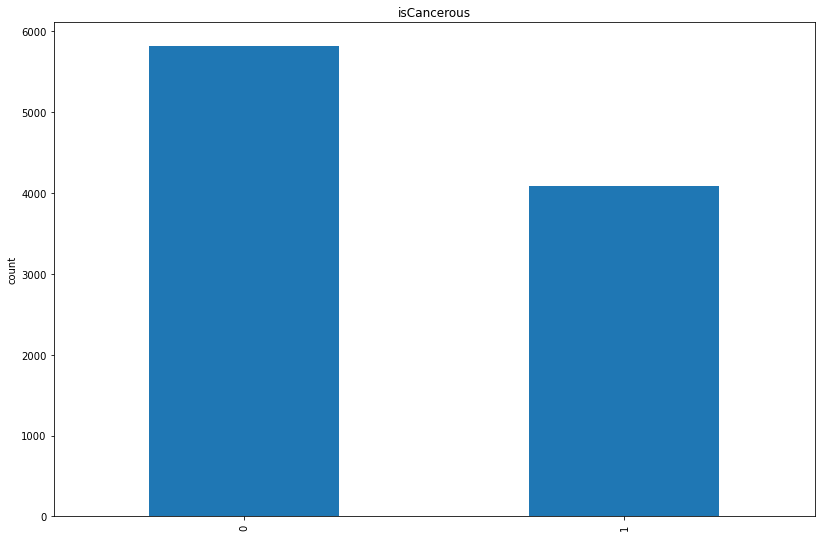

In [3]:
# Plot the datagram represent the number of data of cancerous and non-cancerous 
fig = plt.figure(figsize=(30,20))
ax1=fig.add_subplot(221)
train['isCancerous'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('count')
ax1.set_title('isCancerous')

In [4]:
# count value of 2 classes
train.isCancerous.value_counts()

0    5817
1    4079
Name: isCancerous, dtype: int64

# Data Preparation and Processing

In [5]:
# define new dataframe to store data of each class
train_0 = train[train['isCancerous'] == 0]
train_1 = train[train['isCancerous'] == 1]

In [6]:
# set the number of data of class 1 = number of data of class 0 (balance data)
train_1_balanced = resample(train_1, replace=True, n_samples = len(train_0), random_state = 42)

In [7]:
# combine back to a single dataframe
train_balanced = pd.concat([train_0,train_1_balanced])

In [8]:
# check the distribution: 2 classes should be balanced 
print(train_balanced['isCancerous'].value_counts())

1    5817
0    5817
Name: isCancerous, dtype: int64


In [9]:
# shape of dataframe
train_balanced.shape

(11634, 6)

In [10]:
# display the first 5 rows of the new dataframe
train_balanced.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [11]:
# drop unused columns
train_balanced = train_balanced.drop(['InstanceID', 'patientID',"cellTypeName","cellType"], axis = 1)

In [12]:
# dataframe after dropping column
train_balanced.head()

,ImageName,isCancerous
0,22405.png,0
1,22406.png,0
2,22407.png,0
3,22408.png,0
4,22409.png,0


In [13]:
# read images based on ImageName from CSV file
path = "patch_images/"

# define the path and add as a new column 
train_balanced['path'] = path + train_balanced['ImageName']

# check the dataframe
train_balanced.head()

,ImageName,isCancerous,path
0,22405.png,0,patch_images/22405.png
1,22406.png,0,patch_images/22406.png
2,22407.png,0,patch_images/22407.png
3,22408.png,0,patch_images/22408.png
4,22409.png,0,patch_images/22409.png


In [14]:
# Use the path to read image and convert image into numpy array
train_balanced['image'] = train_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [15]:
# check dataframe
train_balanced.head(1)

,ImageName,isCancerous,path,image
0,22405.png,0,patch_images/22405.png,"[[[242, 213, 237], [240, 210, 234], [236, 206,..."


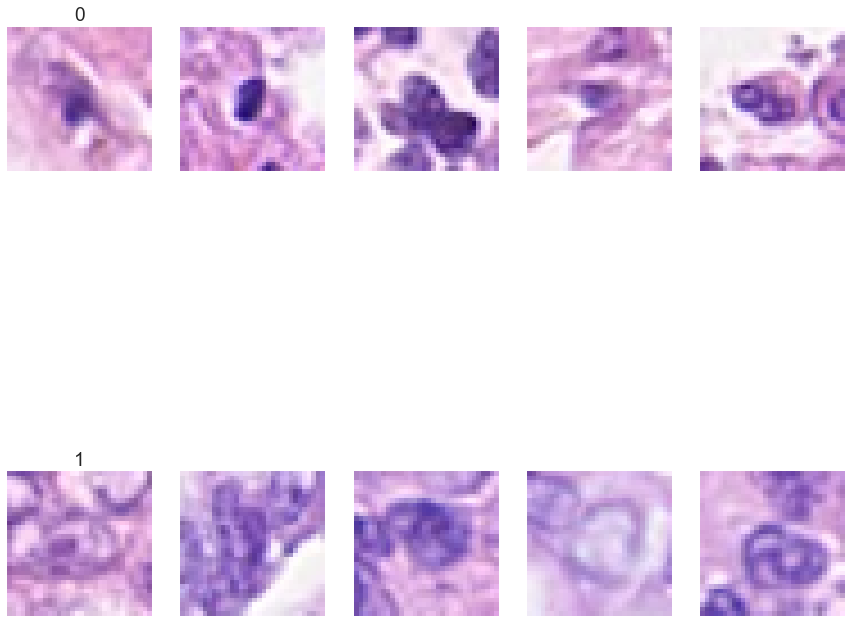

In [45]:
# Plotting some images of each class
fig, m_axs = plt.subplots(2, 5, figsize = (15, 15))
for n_axs, (type_name, type_rows) in zip(m_axs, train_balanced.sort_values(['isCancerous']).groupby('isCancerous')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Extract Training Data using Train_Split_Test

In [16]:
# X is value of images numpy array
X = np.asarray(train_balanced['image'].tolist())

# Scale values to 0:1
X = X/255.

In [17]:
# check the shape of X
X.shape

(11634, 32, 32, 3)

In [18]:
# Assign the label values to Y
Y = train_balanced['isCancerous']

In [47]:
# Convert the Y into 2 classes 
Y_cat = to_categorical(Y, num_classes = 2)

print(Y_cat)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [20]:
# Split data 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=42)

In [21]:
print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_train shape", y_test.shape)

X_train shape (9307, 32, 32, 3)
y_train shape (9307, 2)
X_test shape (2327, 32, 32, 3)
y_train shape (2327, 2)


# Build CNN Model and Training model

In [22]:
# Define Model 
model = Sequential()

# Data input_shape
# Convolution Layer
model.add(Conv2D(32, (3,3), activation="relu", padding ='same',input_shape=(SIZE,SIZE,3)))
model.add(Conv2D(32, (3,3), activation="relu", padding = 'same'))
# Max Pooling 
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout method
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3), activation="relu", padding ='same'))
model.add(Conv2D(64,(3,3), activation="relu", padding ='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation="relu", padding ='same'))
model.add(Conv2D(128, (3,3), activation="relu", padding ='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Flattening
model.add(Flatten())

# Hiden layer
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

# Ouput Layer with activation sigmoid, which good for binary classification
model.add(Dense(2, activation='sigmoid'))

# Summary of model 
model.summary()

# Model Compile
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [23]:
# Training model 
batch_size = int(len(x_train)/100)
epochs = 100

# stop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=0, mode="auto", baseline=None, restore_best_weights=False)
# checkpoint = ModelCheckpoint(filepath ='best_model.h5',monitor='val_loss', save_best_only=True)
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2
)

Epoch 1/100
101/101 - 43s - loss: 0.6895 - acc: 0.5284 - val_loss: 0.6937 - val_acc: 0.4856
Epoch 2/100
101/101 - 36s - loss: 0.6837 - acc: 0.5228 - val_loss: 0.6242 - val_acc: 0.7439
Epoch 3/100
101/101 - 36s - loss: 0.4950 - acc: 0.7795 - val_loss: 0.4333 - val_acc: 0.7765
Epoch 4/100
101/101 - 36s - loss: 0.3940 - acc: 0.8308 - val_loss: 0.2990 - val_acc: 0.8814
Epoch 5/100
101/101 - 36s - loss: 0.3442 - acc: 0.8544 - val_loss: 0.4148 - val_acc: 0.8225
Epoch 6/100
101/101 - 36s - loss: 0.3329 - acc: 0.8662 - val_loss: 0.2715 - val_acc: 0.8951
Epoch 7/100
101/101 - 36s - loss: 0.3113 - acc: 0.8729 - val_loss: 0.2517 - val_acc: 0.9059
Epoch 8/100
101/101 - 36s - loss: 0.2987 - acc: 0.8827 - val_loss: 0.4462 - val_acc: 0.7851
Epoch 9/100
101/101 - 37s - loss: 0.2956 - acc: 0.8788 - val_loss: 0.2574 - val_acc: 0.9020
Epoch 10/100
101/101 - 37s - loss: 0.2804 - acc: 0.8915 - val_loss: 0.4374 - val_acc: 0.7869
Epoch 11/100
101/101 - 36s - loss: 0.2959 - acc: 0.8834 - val_loss: 0.2233 - va

Epoch 90/100
101/101 - 18s - loss: 0.0789 - acc: 0.9698 - val_loss: 0.1899 - val_acc: 0.9437
Epoch 91/100
101/101 - 18s - loss: 0.0885 - acc: 0.9681 - val_loss: 0.2008 - val_acc: 0.9424
Epoch 92/100
101/101 - 18s - loss: 0.0796 - acc: 0.9665 - val_loss: 0.1994 - val_acc: 0.9519
Epoch 93/100
101/101 - 18s - loss: 0.0906 - acc: 0.9685 - val_loss: 0.1558 - val_acc: 0.9502
Epoch 94/100
101/101 - 18s - loss: 0.0853 - acc: 0.9709 - val_loss: 0.1560 - val_acc: 0.9553
Epoch 95/100
101/101 - 18s - loss: 0.0802 - acc: 0.9705 - val_loss: 0.1664 - val_acc: 0.9510
Epoch 96/100
101/101 - 19s - loss: 0.0660 - acc: 0.9748 - val_loss: 0.1760 - val_acc: 0.9596
Epoch 97/100
101/101 - 19s - loss: 0.0752 - acc: 0.9738 - val_loss: 0.1542 - val_acc: 0.9557
Epoch 98/100
101/101 - 19s - loss: 0.0700 - acc: 0.9736 - val_loss: 0.1965 - val_acc: 0.9351
Epoch 99/100
101/101 - 18s - loss: 0.0654 - acc: 0.9751 - val_loss: 0.1618 - val_acc: 0.9575
Epoch 100/100
101/101 - 18s - loss: 0.0749 - acc: 0.9722 - val_loss: 0

In [24]:
# Model Evaluating 
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])
print('Error rate:', score[0])

73/73 [==============================] - 1s 11ms/step - loss: 0.1772 - acc: 0.9484
Test accuracy: 0.9484314322471619
Error rate: 0.17720353603363037


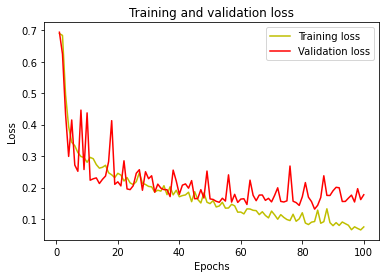

In [25]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

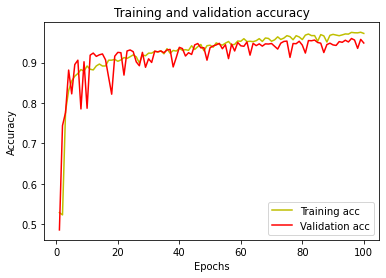

In [26]:
#plot the training and validation accuracy at each epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
# Save Model
model.save('Binary_CNN_Classifier.h5')

In [28]:
# Predict on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 
print(y_pred_classes)

[1 1 0 ... 0 0 1]


In [29]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

[[1104   93]
 [  27 1103]]


<AxesSubplot:>

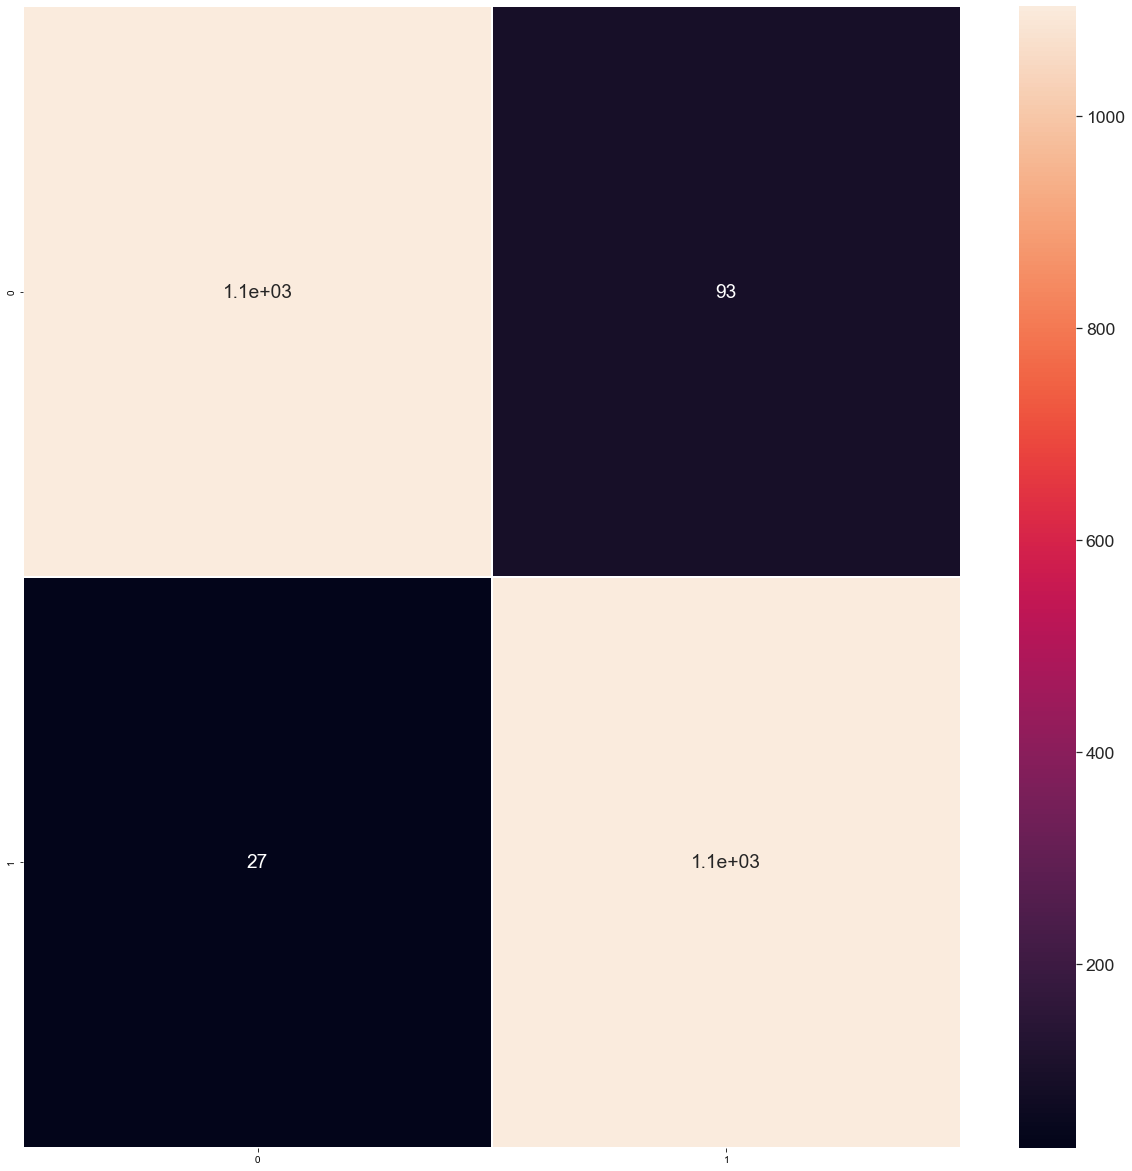

In [30]:
# Plot the heatmap
fig, ax = plt.subplots(figsize=(21,21))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [31]:
# print out classification report
print(classification_report(y_true, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1197
           1       0.92      0.98      0.95      1130

    accuracy                           0.95      2327
   macro avg       0.95      0.95      0.95      2327
weighted avg       0.95      0.95      0.95      2327



Text(0, 0.5, 'Fraction of incorrect predictions')

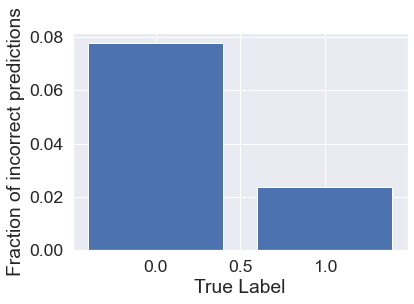

In [32]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(2), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

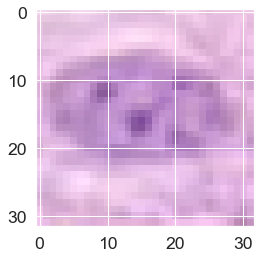

In [33]:
# Input index of image and predict
n = 0
img = X[n]
plt.imshow(img)

In [46]:
input_img = np.expand_dims(img, axis = 0)
y = model.predict(input_img)
print("the predict is", y)
y_pre = np.argmax(y, axis = 1) 
print("The class is",y_pre)
print("The actual result is:", Y[n])

the predict is [[0.98508453 0.01429012]]
The class is [0]
The actual result is: 0


# Testing the prediction of model on the test dataset

In [35]:
# read the testing file
test = pd.read_csv('data_labels_extraData.csv')
test.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [36]:
# read path
path = "patch_images/"
test['path'] = path + test['ImageName']
test.head()

,InstanceID,patientID,ImageName,isCancerous,path
0,12681,61,12681.png,0,patch_images/12681.png
1,12682,61,12682.png,0,patch_images/12682.png
2,12683,61,12683.png,0,patch_images/12683.png
3,12684,61,12684.png,0,patch_images/12684.png
4,12685,61,12685.png,0,patch_images/12685.png


In [37]:
test['image'] = test['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [38]:
test

,InstanceID,patientID,ImageName,isCancerous,path,image
0,12681,61,12681.png,0,patch_images/12681.png,"[[[165, 125, 180], [148, 110, 169], [161, 123,..."
1,12682,61,12682.png,0,patch_images/12682.png,"[[[241, 236, 240], [242, 235, 239], [241, 232,..."
2,12683,61,12683.png,0,patch_images/12683.png,"[[[250, 241, 253], [255, 245, 255], [246, 236,..."
3,12684,61,12684.png,0,patch_images/12684.png,"[[[255, 238, 255], [247, 228, 246], [239, 221,..."
4,12685,61,12685.png,0,patch_images/12685.png,"[[[222, 198, 219], [229, 205, 226], [224, 194,..."
...,...,...,...,...,...,...
10379,20028,99,20028.png,0,patch_images/20028.png,"[[[243, 240, 242], [244, 241, 242], [244, 241,..."
10380,20029,99,20029.png,0,patch_images/20029.png,"[[[206, 172, 214], [218, 185, 226], [221, 187,..."
10381,20030,99,20030.png,0,patch_images/20030.png,"[[[243, 242, 242], [243, 241, 242], [243, 240,..."
10382,20031,99,20031.png,0,patch_images/20031.png,"[[[246, 240, 248], [246, 240, 249], [246, 240,..."


In [39]:
# Convert image into numpy array
X_val = np.asarray(test['image'].tolist())
X_val = X_val/255.

In [40]:
# predict the result of image 
y = model.predict(X_val)
y_pre = np.argmax(y, axis = 1) 
print("The class is",y_pre)
test["predict"] = y_pre

The class is [0 0 0 ... 0 1 0]


In [41]:
# print out classification report
print(classification_report(y_pre, test['isCancerous']))

              precision    recall  f1-score   support

           0       0.53      0.98      0.69      3995
           1       0.97      0.46      0.62      6389

    accuracy                           0.66     10384
   macro avg       0.75      0.72      0.65     10384
weighted avg       0.80      0.66      0.65     10384

